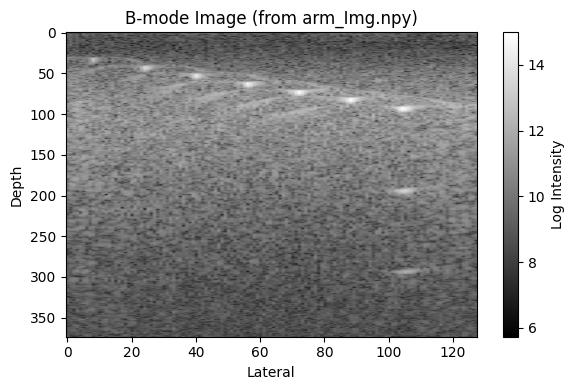

In [14]:
import numpy as np
import matplotlib.pyplot as plt


# 1.이미지 데이터 불러오기
img_path = "/home/mhb0917/의료영상처리/202255646/phantom_Img.npy"
arm_img = np.load(img_path)  # Shape: (374, 128, 1, 100)


# 2. 첫 번째 프레임 선택 및 로그 압축
img_frame = arm_img[:, :, 0, 0]         # 첫 프레임만 선택
img_log = np.log1p(img_frame)           # log(1 + x) 압축


# 3. 시각화
plt.figure(figsize=(6, 4))
plt.imshow(img_log, cmap='gray', aspect='auto')
plt.title("B-mode Image (from arm_Img.npy)")
plt.colorbar(label='Log Intensity')
plt.xlabel("Lateral")
plt.ylabel("Depth")
plt.tight_layout()
plt.show()


In [9]:
from scipy.interpolate import interp1d
import numpy as np

def delayed_sum_beamforming(rf_frame, spacing_mm=0.3, aperture_size=16, speed=1540, fs=7.6e6 * 4.1):
    depth, channels = rf_frame.shape
    dt = 1 / fs
    half = aperture_size // 2
    output = np.zeros((depth, channels))  # 항상 128개의 스캔라인

    for i in range(channels):
        # 경계 보정된 aperture 범위 계산
        start = max(0, i - half)
        end = min(channels, i + half + 1)
        segment = rf_frame[:, start:end]  # (depth, aperture_width)
        sum_line = np.zeros(depth)

        for ch in range(segment.shape[1]):
            lateral_offset = (start + ch - i) * spacing_mm  # 기준 중심 i
            lateral_m = lateral_offset / 1000

            # 지연 거리 계산
            z = np.arange(depth) * dt * speed
            r = np.sqrt(z**2 + lateral_m**2)
            t_delay = r / speed
            s_delay = t_delay / dt

            # 선형 보간으로 delay 적용
            f = interp1d(np.arange(depth), segment[:, ch], bounds_error=False, fill_value=0.0)
            delayed = f(s_delay)
            sum_line += delayed

        output[:, i] = sum_line

    return output


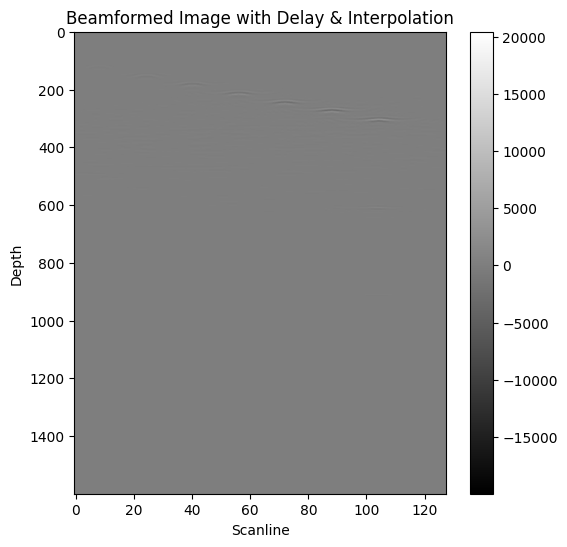

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

rf = np.load("/home/mhb0917/의료영상처리/202255646/phantom_Rfdata.npy")
rf_frame = rf[:, :, 0]  # 첫 번째 프레임 사용

das = delayed_sum_beamforming(rf_frame)  

original_depth = das.shape[0]
target_depth = 1600
scale_factor = target_depth / original_depth

das_resized = zoom(das, (scale_factor, 1))  # (1600, 128)

original_depth = das.shape[0]
target_depth = 1600
scale_factor = target_depth / original_depth

das_resized = zoom(das, (scale_factor, 1))  # shape: (1600, 128)

plt.figure(figsize=(6, 6))
plt.imshow(das_resized, cmap='gray', aspect='auto')
plt.title("Beamformed Image with Delay & Interpolation")
plt.xlabel("Scanline")
plt.ylabel("Depth")
plt.colorbar()
plt.show()


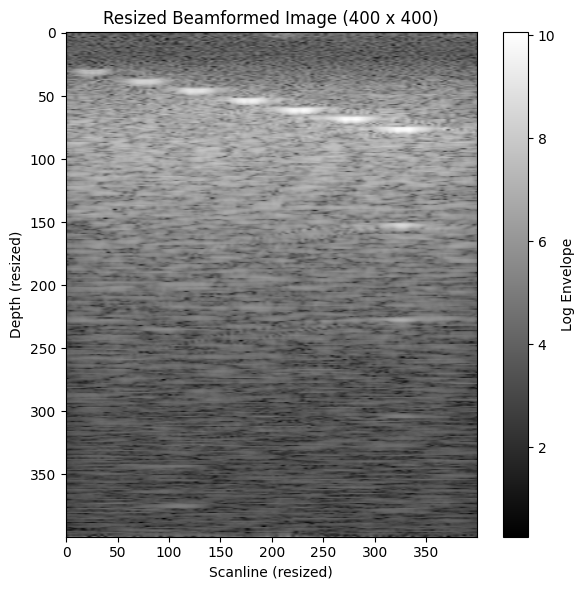

In [ ]:
from scipy.ndimage import zoom
from scipy.signal import hilbert

# 5. Envelope Detection + Log Compression

analytic = hilbert(das_resized, axis=0)   # 각 column(스캔라인) 기준으로 적용
env = np.abs(analytic)  
log_img = np.log1p(env)

# 6. 400 x 400으로 리사이즈
final_img = zoom(log_img, (400 / log_img.shape[0], 400 / log_img.shape[1]))  # (400, 400)

# 7. 리사이즈된 이미지 시각화
plt.figure(figsize=(6, 6))
plt.imshow(final_img, cmap='gray', aspect='auto')
plt.title("Resized Beamformed Image (400 x 400)")
plt.xlabel("Scanline (resized)")
plt.ylabel("Depth (resized)")
plt.colorbar(label='Log Envelope')
plt.tight_layout()
plt.show()
